| | |
|--|--|
| **Names** | *Raoul Fasel & Bouke Regnerus* |
| **Group** | *02* |

# Alzheimer's MRI deep learning



In [14]:
import math

import json

import cv

import numpy as np
import numpy.ma as ma

import scipy as scipy

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

from mpl_toolkits.axes_grid1 import make_axes_locatable

import itertools

from sklearn import svm, datasets
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

import theano
import theano.tensor as T

import keras
from keras import backend as K
from keras.utils import np_utils
from keras.engine import Layer

from keras.layers import Input, Dense, Convolution1D, Convolution2D, MaxPooling2D, Deconvolution2D, UpSampling2D, Reshape, Flatten, ZeroPadding2D, BatchNormalization, Lambda, Dropout, Activation
from keras.layers import Convolution3D, MaxPooling3D
from keras.models import Model, Sequential
from keras.models import model_from_json

from keras.optimizers import SGD, RMSprop, Adam
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing import image

from keras.callbacks import Callback
from keras.models import load_model

from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from vis.utils import utils
from vis.visualization import visualize_saliency

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

theano.config.opennp = True

In [4]:
model_version = 'v1_3d'

channels = 62
img_size_x = 96
img_size_y = 96

batch_size = 128
nb_classes = 3
nb_epoch = 25

c = 0

learning_rate = 0.003
early_stopping_patience = 20

class_names = ["CN", "MCI", "AD"]

In [5]:
"""Custom CMAP"""
# Choose colormap
binary_cmap = cm.binary

# Get the colormap colors
scan_cmap = binary_cmap(np.arange(cm.binary.N))

# Set alpha
scan_cmap[:,-1] = np.linspace(0, 1, cm.binary.N)

# Create new colormap
scan_cmap = ListedColormap(scan_cmap)

In [6]:
"""Get Data"""
c = 0

def load_dataset(dimension = '3d'):
    
    def load_mri_images(filename):
        global c
        
        data = np.load(filename)
        
        tmp = c
        c = tmp + 1
        
        print 'Loaded image set %d of 32.' %c
        
        return data
    
    def imgwise_2d_scaling(data):
        #loop over patients
        for i in range(len(data)):
            for j in range(len(data[i][0])):
                max_val_2d = np.amax(data[i][0][j])

                data[i][0][j] = data[i][0][j].astype('float32')
                data[i][0][j] /= max_val_2d
                
        print 'Executed imagewise 2d scaling.'

        return data

    def imgwise_3d_scaling(data):
         #loop over patients
        for i in range(len(data)):
            max_val_3d = np.amax(data[i][0])

            data[i][0] = data[i][0].astype('float32')
            data[i][0] /= max_val_3d

        print 'Executed imagewise 3d scaling.'
        
        return data
    
    def reshape_mri_images(data):
        #Reshape the loaded dataset to the appropriate format.
        data = np.expand_dims(data,axis=1)
        
        if(dimension == '3d'):
            data = np.reshape(data, (-1, 1, channels, img_size_x, img_size_y))
        
        print 'Reshaped images.'
        
        return data
    
    def load_mri_labels(filename, train_valid_test):
        data = pd.read_csv(filename)

        data = data.loc[data['train_valid_test'] == train_valid_test]
        
        data = np.asarray(data.diagnosis)
        data_new = np.array([])
        
        if(dimension == '2d'):
            for i, item in enumerate(data):
                data_temp = np.array([])
                for i in range(channels):
                    data_temp = np.append(data_temp, item)  
                
                data_new = np.append(data_new, data_temp)
        else:
            data_new = data
            
        data_new = data_new.reshape((-1, 1))
        data_new = data_new.astype(np.int64)
        
        #labels start at 1, normalise them to start at 0.
        data_new = np.subtract(data_new, 1)
        
        data_new = np_utils.to_categorical(data_new, nb_classes)
        
        print 'Loaded labels.'

        return data_new
    
    train_data = load_mri_images('img_array_train_6k_1.npy')
    for i in range(2,23):
        train_cur = load_mri_images('img_array_train_6k_%d.npy' %i)
        train_data = np.vstack((train_data, train_cur))
    train_data = reshape_mri_images(train_data)
    
    val_data = load_mri_images('img_array_valid_6k_1.npy')
    for i in range(2,6):
        valid_cur = load_mri_images('img_array_valid_6k_%d.npy' %i)
        val_data = np.vstack((val_data, valid_cur))
    val_data = reshape_mri_images(val_data)
    
    test_data = load_mri_images('img_array_test_6k_1.npy')
    for i in range(2,6):
        test_cur = load_mri_images('img_array_test_6k_%d.npy' %i)
        test_data = np.vstack((test_data, test_cur))
    test_data = reshape_mri_images(test_data)
    
    if(dimension == '3d'):
        train_data = imgwise_3d_scaling(train_data)
        val_data = imgwise_3d_scaling(val_data)
        test_data = imgwise_3d_scaling(test_data)
    else:
        train_data = imgwise_2d_scaling(train_data)
        val_data = imgwise_2d_scaling(val_data)
        test_data = imgwise_2d_scaling(test_data)
        
    train_labels = load_mri_labels('adni_demographic_master_kaggle.csv', 0)
    val_labels = load_mri_labels('adni_demographic_master_kaggle.csv', 1)
    test_labels = load_mri_labels('adni_demographic_master_kaggle.csv', 2)
    
    print 'Done.'
    
    return train_data, train_labels, test_data, test_labels, val_data, val_labels

In [80]:
def build_cnn(dimension = '3d', activation = 'softmax', heatmap = False, w_path = None, compile_model = True):
    input_3d = (1, channels, img_size_x, img_size_y)
    input_2d = (1, img_size_x, img_size_y)
    
    pool_3d = (2, 2, 2)
    pool_2d = (2, 2)
    
    def global_average_pooling(x):
        return K.mean(x, axis = (2, 3))

    def global_average_pooling_shape(input_shape):
        return input_shape[0:2]
    
    def build_conv_3d():
        model = Sequential()
        
        model.add(Convolution3D(8, 3, 3, 3, name='conv1', input_shape=input_3d))
        model.add(MaxPooling3D(pool_size=pool_3d, name='pool1'))

        model.add(Convolution3D(8, 3, 3, 3, name='conv2'))
        model.add(MaxPooling3D(pool_size=pool_3d, name='pool2'))

        model.add(Convolution3D(8, 3, 3, 3, name='conv3'))
        model.add(MaxPooling3D(pool_size=pool_3d, name='pool3'))
        
        return model
        
    def build_conv_2d():
        model = Sequential()
        
        model.add(Convolution2D(8, 3, 3, name='conv1', input_shape=input_2d))
        model.add(MaxPooling2D(pool_size=pool_2d, name='pool1'))

        model.add(Convolution2D(8, 3, 3, name='conv2'))
        model.add(MaxPooling2D(pool_size=pool_2d, name='pool2'))

        model.add(Convolution2D(8, 3, 3, name='conv3'))
        model.add(MaxPooling2D(pool_size=pool_2d, name='pool3'))
        
        return model
    
    if(dimension == '3d'):
        model = build_conv_3d()
    else:
        model = build_conv_2d()
        
    model.add(Flatten())
    model.add(Dense(2000, activation='relu', name='dense1'))
    model.add(Dropout(0.5, name='dropout1'))

    model.add(Dense(500, activation='relu', name='dense2'))
    model.add(Dropout(0.5, name='dropout2'))

    model.add(Dense(nb_classes, activation=activation, name='softmax'))

    if w_path:
        model.load_weights(w_path)

    opt = keras.optimizers.Adadelta(clipnorm=1.)
    
    if(compile_model):
        model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
    
    print 'Done building model.'

    return model

In [8]:
class SGDLearningRateTracker(Callback):
    def on_epoch_end(self, epoch, logs={}):
        optimizer = self.model.optimizer
        lr = K.eval(optimizer.lr * (1. / (1. + optimizer.decay * optimizer.iterations)))
        print str('\nLR: {:.6f}\n').format(float(lr))
    
def fit_model(model, v, train_data, train_labels, val_data, val_labels):
    model_weights_file = 'img_classifier_weights_%s.h5' %v
    epoch_weights_file = 'img_classifier_weights_%s_{epoch:02d}_{val_acc:.2f}.hdf5' %v
    model_file = 'img_classifier_model_%s.h5' %v
    history_file = 'img_classifier_history_%s.json' %v
    
    def save_model_and_weights():
        model.save(model_file)
        model.save_weights(model_weights_file)
        
        return 'Saved model and weights to disk!'

    def save_model_history(m):
        with open(history_file, 'wb') as history_json_file:
            json.dump(m.history, history_json_file)
        
        return 'Saved model history to disk!'
    
    def visualise_accuracy(m):
        plt.plot(m.history['acc'])
        plt.plot(m.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
      
    def visualise_loss(m):
        plt.plot(m.history['loss'])
        plt.plot(m.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
    
    def model_callbacks():
        checkpoint = ModelCheckpoint(epoch_weights_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
        early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=early_stopping_patience, verbose=1, mode='auto')
        lr_tracker = SGDLearningRateTracker()
        
        return [checkpoint,early_stopping,lr_tracker]
        
    callbacks_list = model_callbacks()

    m = model.fit(train_data,train_labels,batch_size=batch_size,nb_epoch=nb_epoch,verbose=1,shuffle=True,validation_data=(val_data,val_labels),callbacks=callbacks_list)
    
    print save_model_and_weights()
    print save_model_history(m)
    
    visualise_accuracy(m)
    visualise_loss(m)
    
    return m

In [9]:
def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return activations

In [10]:
def evaluate_model(m, weights, test_data, test_labels):    
    def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
     
    plt.close('all')

    m.load_weights(weights)
    m.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    print "Done compiling model."
    
    prediction = m.predict(test_data)
    prediction_labels = np_utils.to_categorical(np.argmax(prediction, axis=1), nb_classes)
    
    print 'Accuracy on test data:', accuracy_score(test_labels, prediction_labels)

    print 'Classification Report'
    print classification_report(test_labels, prediction_labels, target_names = class_names)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(prediction, axis=1))
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes = class_names, normalize=False, title='Confusion matrix')

    plt.show()

In [31]:
#load data
train_data, train_labels, test_data, test_labels, val_data, val_labels = load_dataset(dimension = '3d')

Loaded image set 1 of 32.
Loaded image set 2 of 32.
Loaded image set 3 of 32.
Loaded image set 4 of 32.
Loaded image set 5 of 32.
Loaded image set 6 of 32.
Loaded image set 7 of 32.
Loaded image set 8 of 32.
Loaded image set 9 of 32.
Loaded image set 10 of 32.
Loaded image set 11 of 32.
Loaded image set 12 of 32.
Loaded image set 13 of 32.
Loaded image set 14 of 32.
Loaded image set 15 of 32.
Loaded image set 16 of 32.
Loaded image set 17 of 32.
Loaded image set 18 of 32.
Loaded image set 19 of 32.
Loaded image set 20 of 32.
Loaded image set 21 of 32.
Loaded image set 22 of 32.
Reshaped images.
Loaded image set 23 of 32.
Loaded image set 24 of 32.
Loaded image set 25 of 32.
Loaded image set 26 of 32.
Loaded image set 27 of 32.
Reshaped images.
Loaded image set 28 of 32.
Loaded image set 29 of 32.
Loaded image set 30 of 32.
Loaded image set 31 of 32.
Loaded image set 32 of 32.
Reshaped images.
Executed imagewise 3d scaling.
Executed imagewise 3d scaling.
Executed imagewise 3d scaling.
L

In [12]:
#build model
model = build_cnn(dimension = '3d')

Done building model.


In [82]:
## fit_model(model, model_version, train_data, train_labels, val_data, val_labels)

In [ ]:
model_2d = build_cnn(dimension = '2d')

fit_model(model, model_version, train_data, train_labels, val_data, val_labels)

Train on 2109 samples, validate on 435 samples
Epoch 1/50
  32/2109 [..............................] - ETA: 775s - loss: 0.1307 - acc: 0.9375

Done building model.
Done compiling model.
Accuracy on test data: 0.810234541578
Classification Report
             precision    recall  f1-score   support

         CN       0.98      0.96      0.97       159
        MCI       0.69      0.79      0.74       157
         AD       0.77      0.67      0.72       153

avg / total       0.82      0.81      0.81       469



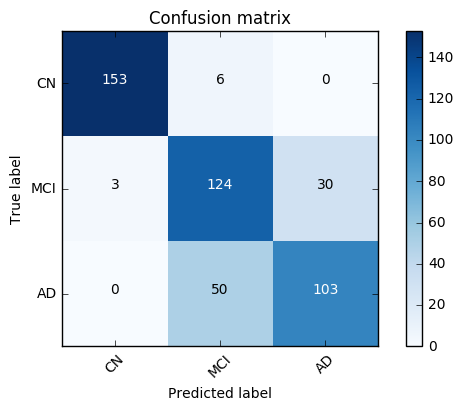

In [13]:
loaded_model = build_cnn(dimension = '3d')
evaluate_model(loaded_model, 'img_classifier_weights_v5.h5', test_data, test_labels)  

In [81]:
def save_activations():
    i = 0

    X = test_data[i:i+1]

    W = np.array(get_activations(model, 2, X))

    W = np.squeeze(W)

    print W.shape

    plt.close('all')

    c = 0

    for w in W:
        print w.shape
        X, Y = np.meshgrid(np.linspace(0,1,w.shape[1]), np.linspace(0,1,w.shape[2]))

        zlim = float(w.shape[0] - 1)

        # create the figure
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_zlim((0.,zlim))
        ax.axis('off')

        for i, d in enumerate(w):
            ax.contourf(X, Y, d, 100, zdir='z', offset=i, interpolation='nearest', cmap=scan_cmap, aspect='equal')

        plt.savefig('img_c2_%s_2.png' %c, transparent=True)
        plt.close('all')
        c += 1


Filters 0


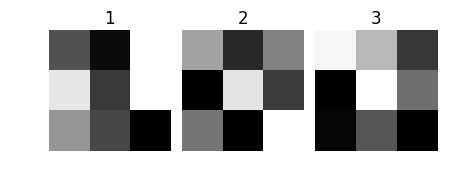

Filters 1


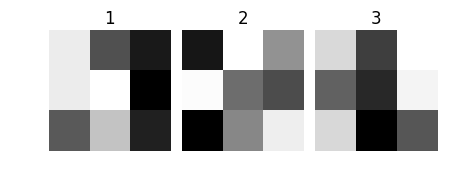

Filters 2


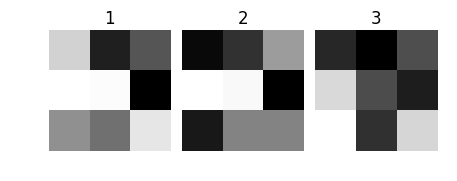

Filters 3


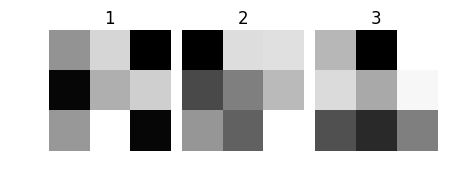

Filters 4


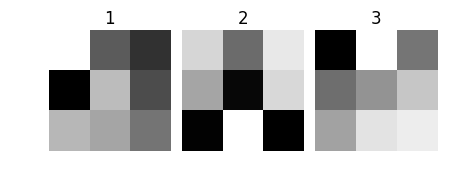

Filters 5


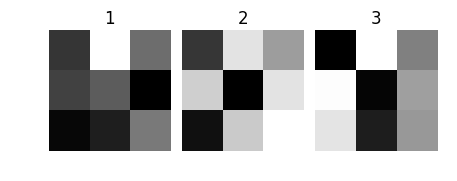

Filters 6


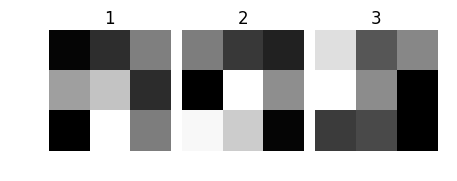

Filters 7


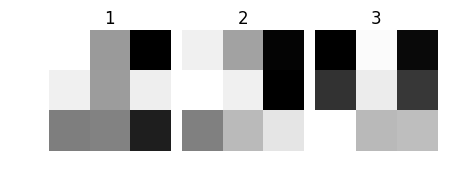

In [322]:
# Visualize weights
W = model.layers[0].W.get_value(borrow=True)
W = np.squeeze(W)

plot_x = 1
plot_y = 3

plot_range = plot_x * plot_y

for i, w in enumerate(W):
    print 'Filters %s' %i
    
    X, Y = np.meshgrid(np.linspace(0,1,w.shape[1]), np.linspace(0,1,w.shape[2]))

    zlim = float(w.shape[0] - 1)

    # create the figure
    fig = plt.figure()
    
    fig, axs = plt.subplots(plot_x,plot_y, figsize=(5, 5))
    fig.subplots_adjust(hspace = .5, wspace=.1)

    for ax, d in zip(axs.ravel(), range(plot_range)): ax.axis('off')

    i = 0
    for ax, d in zip(axs.ravel(), w):
        i = i + 1
        ax.imshow(d, interpolation='nearest', cmap=cm.binary)
        ax.set_title(str(i))
    c += 1
    
    plt.show()
    plt.close('all')

In [12]:
demographics = np.asarray(pd.read_csv('adni_demographic_master_kaggle.csv'))

def get_subject(subject_id):
    scan_range = train_data[subject_id][0]
    demographic = demographics[subject_id]
    
    return demographic, scan_range  

In [29]:
print score

[0.34275584100787321, 0.87846481990712533]


[0 20051021 2 'F' 70.9973]
Done building model.
(8, 28, 45, 45)


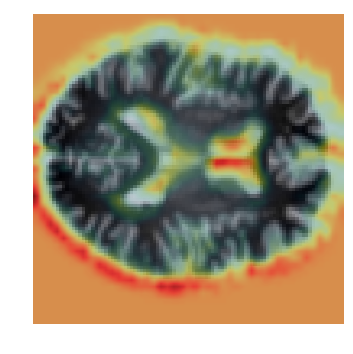

In [241]:
subject = get_subject(0)

print subject[0]


img = np.expand_dims(np.expand_dims(subject[1],axis=0),axis=0)

i = 1

model = build_cnn(dimension = '3d')

W = np.array(get_activations(model, 2, img))

W = np.squeeze(W)
img = np.squeeze(img)

print W.shape

w = W[5][14]

# w /= np.amax(w)
w = scipy.misc.imresize(w, (img_size_x, img_size_y))

plt.figure()

jet_cmap = plt.cm.jet

# Get the colormap colors
heatmap = jet_cmap(np.arange(jet_cmap.N))

# Set alpha
heatmap[:,-1] = np.linspace(0, 1, jet_cmap.N)

# Create new colormap
heatmap = ListedColormap(heatmap)

plt.axis('off')

plt.imshow(img[31], interpolation='nearest', cmap=cm.binary)

plt.imshow(w, cmap=heatmap, alpha=.9, interpolation='bilinear')

plt.show()

Subject: [0 20051021 2 'F' 70.9973]


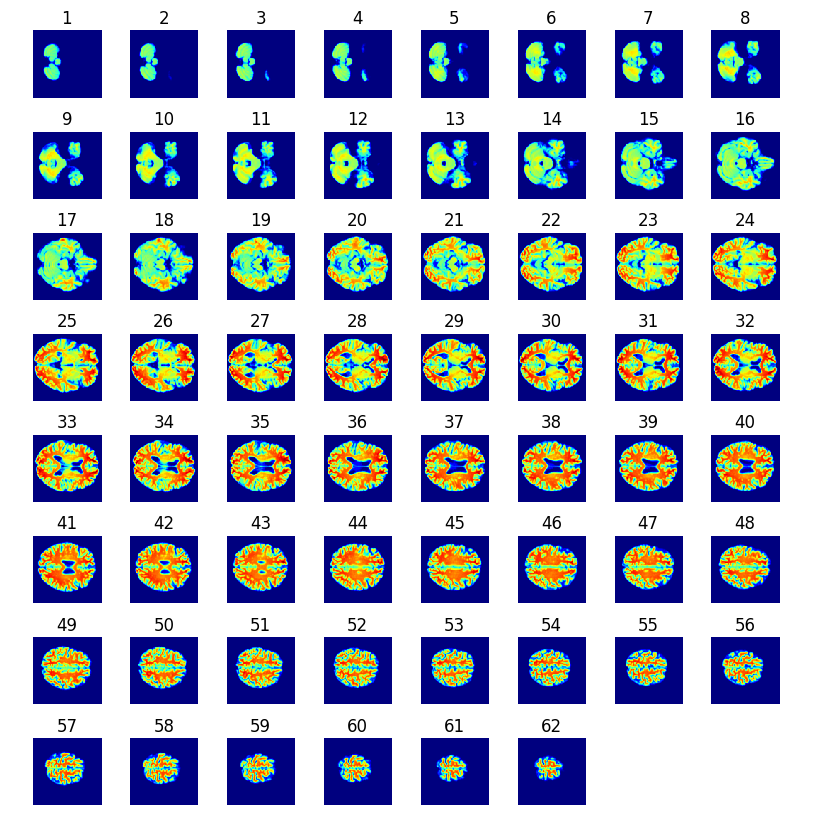

In [242]:
print "Subject:", subject[0]

plt.close('all')

plot_x = 8
plot_y = 8

plot_range = plot_x * plot_y

fig, axs = plt.subplots(plot_x,plot_y, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.001)

for ax, d in zip(axs.ravel(), range(plot_range)): ax.axis('off')
    
i = 0
for ax, d in zip(axs.ravel(), subject[1]):
    i = i + 1
    ax.imshow(d, interpolation='nearest', vmin=0, vmax=1, cmap=jet_cmap)
    ax.set_title(str(i))

plt.show()

Subject: [0 20051021 2 'F' 70.9973]


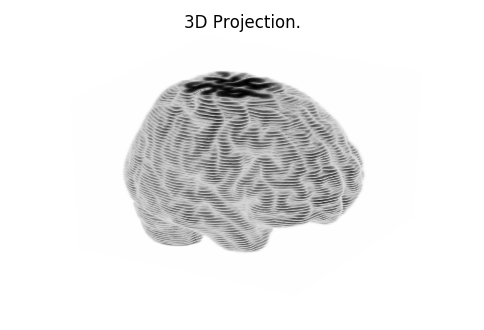

In [290]:
subject = get_subject(0)

print "Subject:", subject[0]

X, Y = np.meshgrid(np.linspace(0,1,subject[1].shape[1]), np.linspace(0,1,subject[1].shape[2]))
zlim = float(subject[1].shape[0] - 1)

# create the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim((0.,zlim))
ax.axis('off')
ax.set_title("3D Projection.")
        
for  i, d in enumerate(subject[1]):
    ax.contourf(X, Y, d, 100, zdir='z', offset=i, cmap=scan_cmap, aspect='equal')

plt.show()